# Thermocouple Temperature Forecasting

This notebook demonstrates how to predict future temperatures for the Blast Furnace thermocouples using historical data.

**Goal:** Predict temperatures for the next 6 months (180 days).
**Models Compared:** Linear Regression, Ridge Regression, Random Forest, Gradient Boosting, SVR, KNN.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Load Data
file_path = 'g:/Other computers/My Laptop/Documents/Thermocouple Project/thermocouple_data_cleaned.csv'
df = pd.read_csv(file_path)
df.rename(columns={'Sl No.': 'TC_ID', 'MEASUREDATE': 'Date', 'VALUE': 'Temp'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Select Target TC
# target_tc_id = df['TC_ID'].value_counts().idxmax()
target_tc_id = 102 # <--- ENTER YOUR DESIRED TC_ID HERE (e.g., 1, 272, 235)
print(f"Forecasting for Thermocouple: {target_tc_id}")

data = df[df['TC_ID'] == target_tc_id].sort_values('Date').copy()
data = data[(data['Temp'] > 50) & (data['Temp'] < 2000)] # Remove outliers

# Feature Engineering
def create_features(df):
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['DaysIndex'] = (df['Date'] - df['Date'].min()).dt.days
    return df

data = create_features(data)
features = ['Year', 'Month', 'DayOfYear', 'DaysIndex']
target = 'Temp'

# Split Data
X = data[features]
y = data[target]
train_size = int(len(data) * 0.9)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

Forecasting for Thermocouple: 102


## Compare Models
We will train different models and compare their Mean Absolute Error (MAE) to see which one performs best.

Training Linear Regression...
Linear Regression MAE: 373.88
Training Ridge Regression...
Ridge Regression MAE: 363.08
Training Random Forest...
Random Forest MAE: 385.14
Training Gradient Boosting...
Gradient Boosting MAE: 439.60
Training Support Vector Regressor...
Support Vector Regressor MAE: 515.12
Training K-Neighbors Regressor...
K-Neighbors Regressor MAE: 394.49


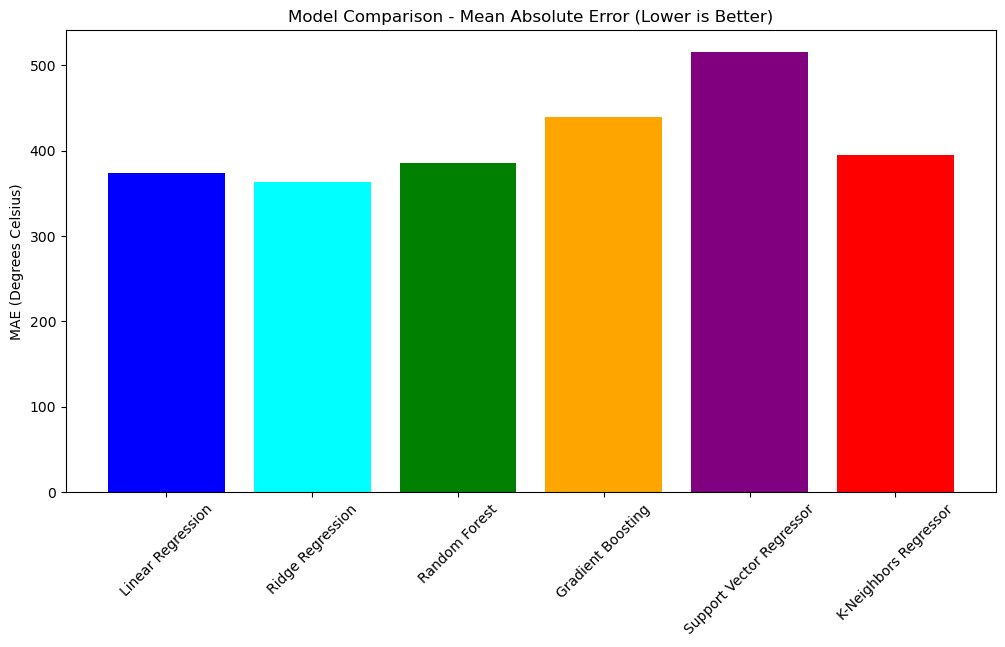

Best Model: Ridge Regression


In [15]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42),
    "Support Vector Regressor": SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1),
    "K-Neighbors Regressor": KNeighborsRegressor(n_neighbors=5)
}

results = {}
predictions = {}

for name, model in models.items():
    print(f"Training {name}...")
    try:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        mae = mean_absolute_error(y_test, preds)
        results[name] = mae
        predictions[name] = preds
        print(f"{name} MAE: {mae:.2f}")
    except Exception as e:
        print(f"Error training {name}: {e}")

# Plot MAE Comparison
plt.figure(figsize=(12, 6))
plt.bar(results.keys(), results.values(), color=['blue', 'cyan', 'green', 'orange', 'purple', 'red'])
plt.title('Model Comparison - Mean Absolute Error (Lower is Better)')
plt.ylabel('MAE (Degrees Celsius)')
plt.xticks(rotation=45)
plt.show()

# Identify Best Model
best_model_name = min(results, key=results.get)
best_model = models[best_model_name]
print(f"Best Model: {best_model_name}")


## Visualize Best Model Forecast
We use the best performig model to visualize the validation fit.

Best Model: Ridge Regression


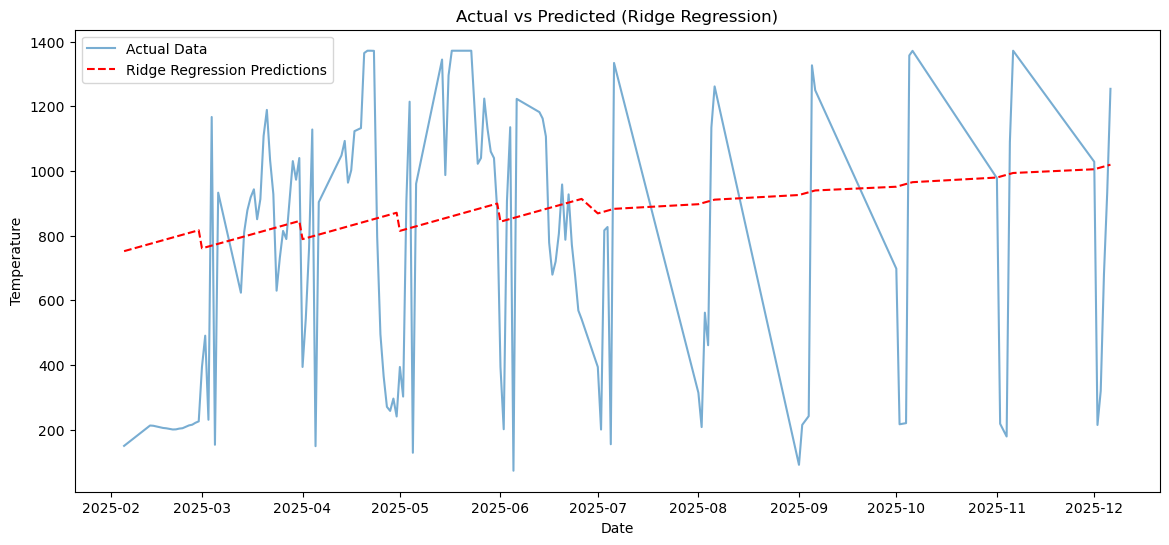

In [16]:
best_model_name = min(results, key=results.get)
print(f"Best Model: {best_model_name}")

# Get dates for test set
test_dates = data.iloc[train_size:]['Date']

plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test, label='Actual Data', alpha=0.6)
plt.plot(test_dates, predictions[best_model_name], label=f'{best_model_name} Predictions', linestyle='--', color='red')
plt.title(f'Actual vs Predicted ({best_model_name})')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Forecast Validation with New 6-Month Dataset

We will now validate our model using the newly provided 6-month dataset (`New_6M_Dataset.xlsx`).

**Steps:**
1. Load data from all sheets (Iterative loading for memory efficiency).
2. Filter for Target Thermocouple (default TC 102).
3. Align features (Date, DaysIndex) with training data.
4. Predict and Compare.

In [11]:
# Validation Settings
VAL_FILE = r'g:/Other computers/My Laptop/Documents/Thermocouple Project/New_6M_Dataset.xlsx'

# --- Exact Logic from validate_forecast.py for Validation Loading (Optimized) ---
print("Loading validation data (Iterative Filtering with Early Stop)...")
xl = pd.ExcelFile(VAL_FILE)
cols = ['TAGID', 'MEASUREDATE', 'VALUE']
val_dfs = []
data_found = False # Flag to track if we started finding data

def process_sheet_df(df_chunk, target_id):
    # Ensure only 3 columns
    df_chunk = df_chunk.iloc[:, :3]
    df_chunk.columns = cols
    
    # Extract TC_ID
    # Handle potential non-numeric tags
    df_chunk['TC_ID'] = pd.to_numeric(df_chunk['TAGID'].astype(str).str[-3:], errors='coerce')
    
    # Filter immediately
    filtered = df_chunk[df_chunk['TC_ID'] == target_id].copy()
    
    # Cleanup
    del df_chunk
    return filtered

# Load all sheets
for sheet in xl.sheet_names:
    if sheet == 'SQL': continue
    print(f"Processing {sheet}...")
    try:
        if sheet == xl.sheet_names[0]:
             df_part = xl.parse(sheet)
             # If headers match standard, rename
             df_part.rename(columns={'TAGID': 'TAGID', 'MEASUREDATE': 'MEASUREDATE', 'VALUE': 'VALUE'}, inplace=True)
        else:
             df_part = xl.parse(sheet, header=None)

        if not df_part.empty:
            chunk_res = process_sheet_df(df_part, TARGET_TC_ID)
            if not chunk_res.empty:
                val_dfs.append(chunk_res)
                data_found = True
            elif data_found:
                # We found data in previous sheets but this one is empty for target.
                # Assuming serial arrangement, we are done.
                print(f"Data for TC {TARGET_TC_ID} ended. Stopping at {sheet}.")
                break
    except Exception as e:
        print(f"Skipping {sheet}: {e}")

if val_dfs:
    val_df = pd.concat(val_dfs, ignore_index=True)
    val_df = val_df.rename(columns={'MEASUREDATE': 'Date', 'VALUE': 'Temp'})
    
    # Process Dates (Logic from process_data)
    val_df['Date'] = pd.to_datetime(val_df['Date'], dayfirst=True, errors='coerce')
    val_df = val_df.dropna(subset=['Date', 'Temp'])
    val_df = val_df.sort_values('Date')
    
    print(f"Validation Data Loaded: {len(val_df)} records for TC {TARGET_TC_ID}")
else:
    print("No data found for target TC.")


Loading validation data (Iterative Filtering with Early Stop)...
Processing THERMOCOUPLETAGVALUES1HR...
Processing Sheet1...
Data for TC 102 ended. Stopping at Sheet1.


C:\Users\sahoo\AppData\Local\Temp\ipykernel_38688\3284211405.py:57: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  val_df['Date'] = pd.to_datetime(val_df['Date'], dayfirst=True, errors='coerce')


Validation Data Loaded: 4416 records for TC 102


In [13]:
# 2. Feature Engineering
# Note: DaysIndex must be relative to the original Training Start Date

TRAIN_START_DATE = None
# Try to find the training data subset used for the model
if 'data' in locals() and not data.empty:
    TRAIN_START_DATE = data['Date'].min()
elif 'df' in locals() and not df.empty:
    # Filter for TARGET_TC_ID just like training did to get correct start date
    temp_train_subset = df[df['TC_ID'] == TARGET_TC_ID]
    if not temp_train_subset.empty:
        TRAIN_START_DATE = temp_train_subset['Date'].min()

if TRAIN_START_DATE is None:
    print("Warning: Could not determine training start date. Using Validation start (will cause offset).")
    TRAIN_START_DATE = val_df['Date'].min()
else:
    print(f"Using Training Start Date: {TRAIN_START_DATE}")

val_df['Year'] = val_df['Date'].dt.year
val_df['Month'] = val_df['Date'].dt.month
val_df['DayOfYear'] = val_df['Date'].dt.dayofyear
# Use .dt.days to match training logic exactly
val_df['DaysIndex'] = (val_df['Date'] - TRAIN_START_DATE).dt.days

X_val = val_df[['Year', 'Month', 'DayOfYear', 'DaysIndex']]
y_val_actual = val_df['Temp']


Using Training Start Date: 2020-01-07 00:00:00


--- Validation Results on New 6M Data ---
MAE: 685.10
RMSE: 724.94
Training Data Ends: 2025-12-06 00:00:00
Full timeframe plot saved to full_timeframe_forecast.png


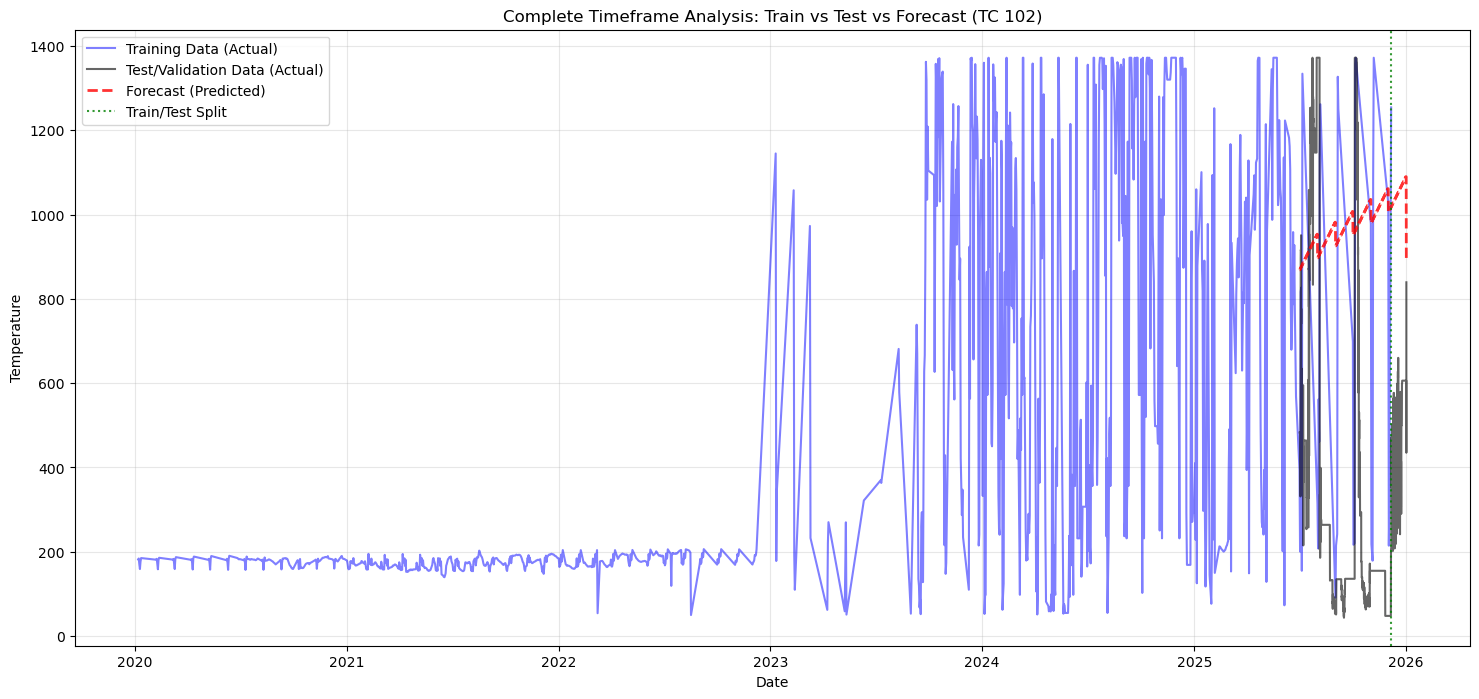

In [17]:
# 3. Predict & Evaluate
# using 'best_model' from previous cells

if 'best_model' in locals():
    y_val_pred = best_model.predict(X_val)
    
    mae_val = mean_absolute_error(y_val_actual, y_val_pred)
    rmse_val = np.sqrt(mean_squared_error(y_val_actual, y_val_pred))
    
    print("--- Validation Results on New 6M Data ---")
    print(f"MAE: {mae_val:.2f}")
    print(f"RMSE: {rmse_val:.2f}")
    
    # --- Full Timeframe Visualization (Train vs Test vs Predicted) ---
    plt.figure(figsize=(18, 8))
    
    # 1. Plot Training Data (Historical)
    # We assume 'data' contains the filtered training data for the specific TC_ID
    if 'data' in locals() and not data.empty:
        plt.plot(data['Date'], data['Temp'], label='Training Data (Actual)', color='blue', alpha=0.5)
        last_train_date = data['Date'].max()
        print(f"Training Data Ends: {last_train_date}")
    elif 'df' in locals() and not df.empty:
         # Fallback if 'data' was overwritten, try to re-filter df for plot
         temp_train_plot = df[df['TC_ID'] == TARGET_TC_ID].sort_values('Date')
         plt.plot(temp_train_plot['Date'], temp_train_plot['Temp'], label='Training Data (Actual)', color='blue', alpha=0.5)
         last_train_date = temp_train_plot['Date'].max()
    else:
        print("Warning: Training data not available for plotting.")
        last_train_date = val_df['Date'].min()

    # 2. Plot Validation/Test Data (Actual)
    plt.plot(val_df['Date'], y_val_actual, label='Test/Validation Data (Actual)', color='black', alpha=0.6)
    
    # 3. Plot Predicted Data
    plt.plot(val_df['Date'], y_val_pred, label='Forecast (Predicted)', color='red', linestyle='--', alpha=0.8, linewidth=2)
    
    # Decoration
    plt.axvline(x=last_train_date, color='green', linestyle=':', label='Train/Test Split', alpha=0.8)
    plt.title(f"Complete Timeframe Analysis: Train vs Test vs Forecast (TC {TARGET_TC_ID})")
    plt.xlabel("Date")
    plt.ylabel("Temperature")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Save plot
    plot_filename = 'full_timeframe_forecast.png'
    plt.savefig(plot_filename)
    print(f"Full timeframe plot saved to {plot_filename}")
    plt.show()
else:
    print("Error: 'best_model' not found. Please run the training cells above first.")
